In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

# Constantes

In [2]:
# Rutas de S3
S3_REFINED_URI = 's3://proyecto-integrador-20212-pregrado/datasets/refined/'

# Clusterización de las acciones con K-means
 En este caso se usará cada día como una variable y cada acción como un registro porque se quieren clasificar las acciones en diferentes clusters.

In [3]:
# Cargar los retornos
df_returns = pd.read_parquet(f'{S3_REFINED_URI}matriz_retornos.parquet')
df_returns.head()

,A,AA,AAN,AAP,AAPL,ABBV,ABT,ACN,ADBE,ADM,...,WYND,WYNN,XEL,XOM,XRAY,XYL,YNDX,YUM,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,1.850863,0.285036,0.748045,3.485500,-1.429295,1.256524,1.323722,0.264806,0.016866,0.861868,...,-1.151932,-1.204273,0.000000,0.150633,0.730536,0.0,0.775194,0.558734,0.691866,-0.619387
2014-01-04,-0.524201,0.142113,-0.269997,-0.212164,-0.704820,-0.152730,-0.038805,-0.134936,-0.236088,-0.254042,...,-0.027582,-0.035702,-0.181488,-0.220596,-0.145048,0.0,0.000000,-0.039688,0.083794,-0.124649
2014-01-06,-0.342526,0.000000,-0.135364,-0.921332,0.862324,-3.269598,1.423395,-0.687876,-1.183232,0.347303,...,0.041385,0.219388,-0.581818,0.221083,-0.674414,0.0,0.093240,0.463208,-0.569324,0.031201
2014-01-07,1.172116,-0.047304,-1.660454,0.947783,-0.970411,-0.553469,-0.612401,0.841064,0.598700,-0.946008,...,-0.799779,2.433437,1.627652,1.263411,1.472684,0.0,1.141127,1.027533,-0.235770,0.218341
2014-01-08,1.533101,2.082347,1.550655,-0.017715,0.584806,0.298151,0.333761,0.711395,-0.119027,-1.374330,...,0.778426,1.570498,-0.125967,-0.445589,0.144328,0.0,-0.990099,0.078237,1.080351,-1.027077


In [4]:
# Como cada acción es una observación, se debe usar la transpuesta
data = df_returns.T

In [5]:
# Definición de k
k = 11
# Clustering con K-Means
labels = KMeans(n_clusters=k, random_state=0).fit_predict(data)
# Agregar las etiquetas como columna a los datos
data['label'] = labels

In [6]:
# Graficar los resultados usando como coordenadas los dos componentes principales
pca = PCA(2)
pca_data = pca.fit_transform(data)

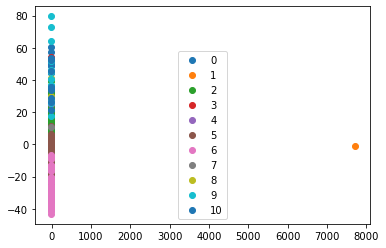

In [7]:
for lab in np.unique(labels):
    plt.scatter(pca_data[labels == lab, 0],pca_data[labels == lab, 1], label=lab)
    
plt.legend()
plt.show();

In [8]:
outlier = list(data[labels == 1].index)
print(f'Las siguientes acciones son outliers y se eliminarán de la gráfica:\n {outlier}')

Las siguientes acciones son outliers y se eliminarán de la gráfica:
 ['YNDX']


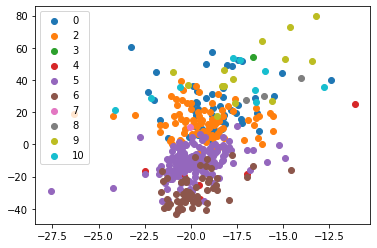

In [9]:
for lab in np.unique(labels):
    if lab == 1:
        continue
    plt.scatter(pca_data[labels == lab, 0],pca_data[labels == lab, 1], label=lab)
    
plt.legend()
plt.show();

A pesar de que en algunos casos hay clusters claros, en otros no hay una división tan clara de las acciones y los clusters a los que pertenecen. Esto también puede pasar porque la clusterización fue hecha en una dimensión mucho más alta que la que se puede graficar.

In [10]:
# Convertir las columnas en texto
string_dates = list(map(lambda x: x.strftime('%Y-%m-%d'), df_returns.index)) + ['label']
data.columns = string_dates

# Guardar la matriz de retornos con etiquetas en S3
data.to_parquet(f'{S3_REFINED_URI}matriz_retornos_etiquetada.parquet')